In [1]:
!pip install natsort

In [2]:
#import necessary libraries

import os
import cv2
import random
import itertools
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance

import sklearn
import numpy as np
np.random.seed(2)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
                                           vgg16, densenet)

In [4]:
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}
# To use => myNet = models['densenet']() 

preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

## Computing Error Rate Analysis
- source = https://stackoverflow.com/a/62010096/6118987

In [5]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

## Test on a Authentic image

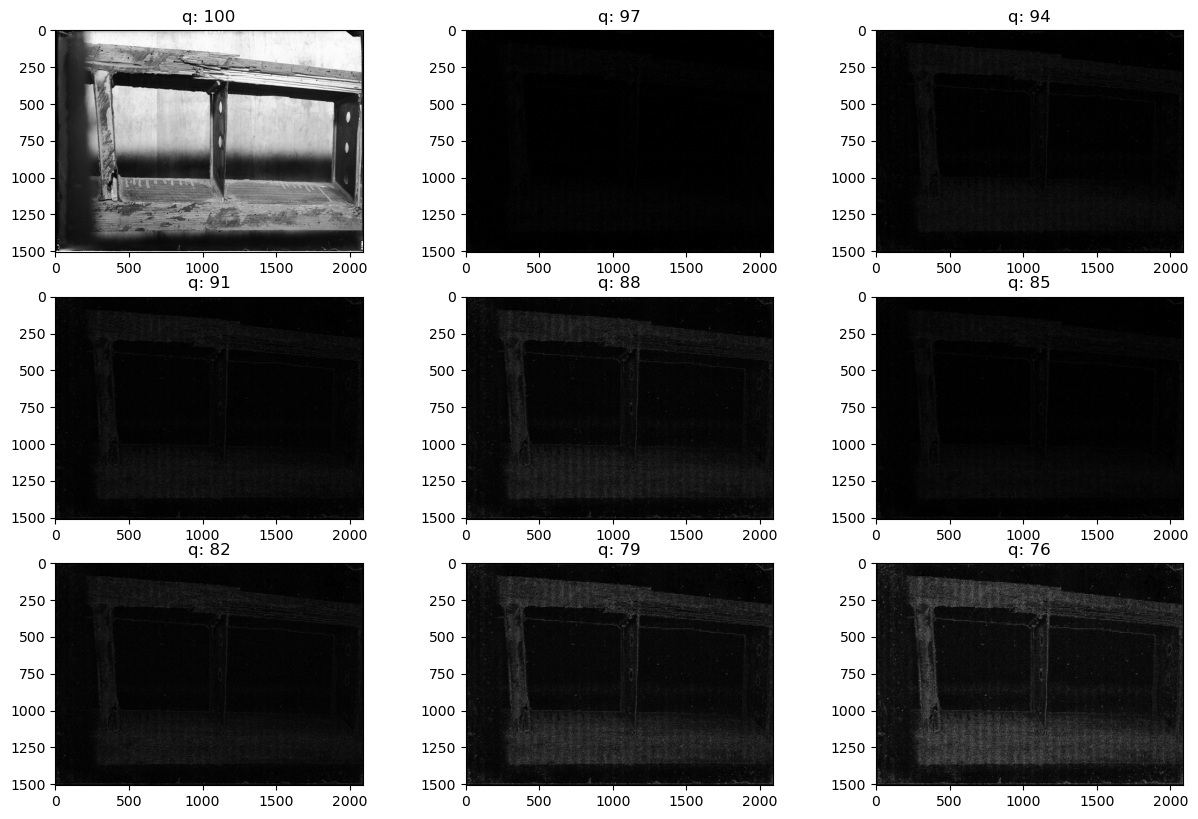

In [13]:
p = random_sample("C:/Users/shake/Documents/UniTrento/Third Semester/AI Challange/sample_images/")
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

## Test on a tampered-fake image 

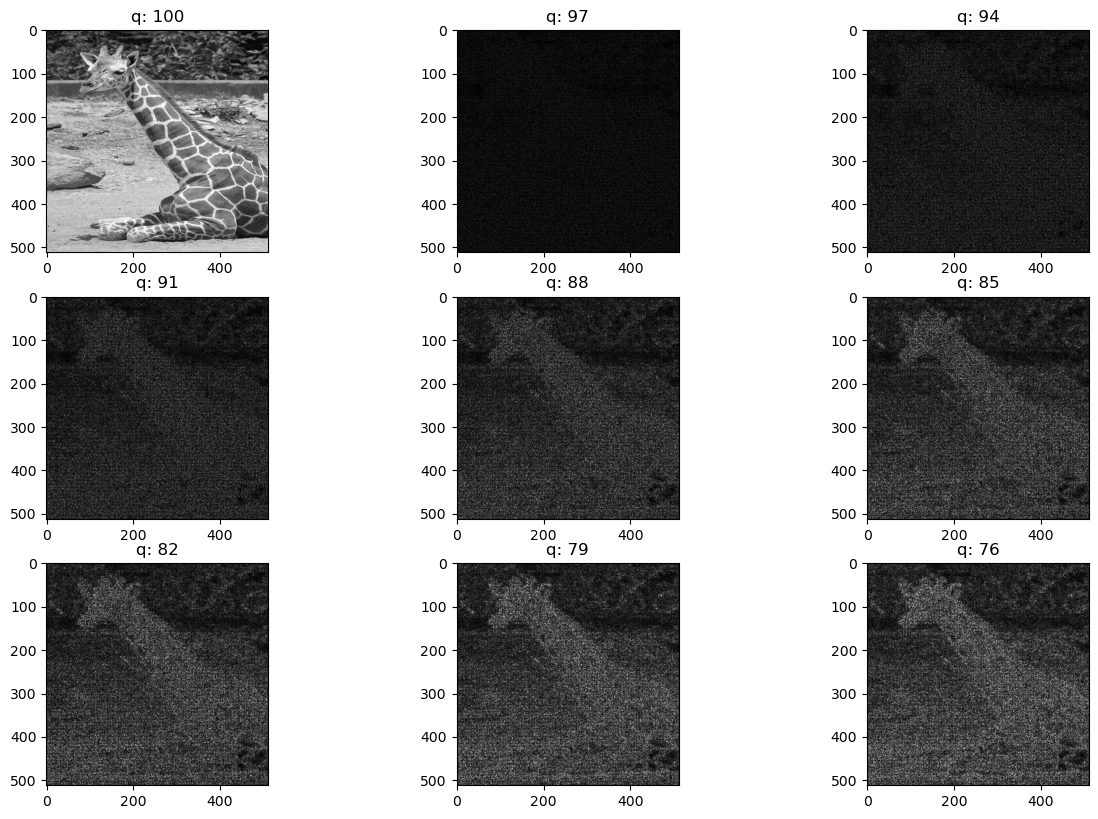

In [42]:
p = random_sample("C:/Users/shake/Documents/UniTrento/Third Semester/AI Challange/damage_insertion_dataset/data/test/image/")
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()## Test on a spliced fake image

## Test on a spliced-fake image

In [16]:
@tf.function
def tensor_aug(img):
    img = tf.image.random_flip_left_right(img, 5)
    img = tf.image.random_flip_up_down(img, 5)
    return img

@tf.function
def batch_aug(images, labels):
    images = tf.map_fn(lambda img: tensor_aug(img), images)
    return images, labels

def ela_process(file_path):
    # https://www.tensorflow.org/guide/data
    QUALITY = 95
    SCALE = 15
    LABELS = np.array(['Au', 'Tp'])
    
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == LABELS
    # Integer encode the label
    label = tf.argmax(one_hot)
    label = tf.cast(label, tf.float32)
    
    # Generate the image
    orig = cv2.imread(file_path.numpy().decode('utf-8'))
    orig = cv2.resize(orig, (224, 224), interpolation = cv2.INTER_AREA)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    # Augmentation
#     orig = albumentation_aug(orig)
    # Save it in buffer
    _, buffer = cv2.imencode(".jpg", orig, [cv2.IMWRITE_JPEG_QUALITY, QUALITY])
    # get it from buffer and decode it to numpy array
    compressed_img = cv2.imdecode(np.frombuffer(buffer, np.uint8), cv2.IMREAD_COLOR)

    # Compute the absolute difference
    diff = SCALE * (cv2.absdiff(orig, compressed_img))
    img = preprocess['xception'](diff)
    
    return img, label

In [21]:
jpg_pattern = 'C:/Users/shake/Documents/UniTrento/Third Semester/AI Challange/sample_images/*jp*g'
tif_pattern = 'C:/Users/shake/Documents/UniTrento/Third Semester/AI Challange/si/*jp*g'

jpg_files = tf.data.Dataset.list_files(tif_pattern)
tif_files = tf.data.Dataset.list_files(jpg_pattern)

data_ds = jpg_files.concatenate(tif_files)

tensor_preprocess = lambda x: tf.py_function(ela_process, [x], [tf.float32, tf.float32])

n_data = data_ds.cardinality().numpy()
n_val = int(.2 * n_data)
data_ds = data_ds.shuffle(n_data)

train_ds = data_ds.skip(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).map(
    batch_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_ds = data_ds.take(n_val).map(
    tensor_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

for img, label in train_ds:
    print(label)
    break

tf.Tensor([0. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


## Checking the generated images

### Utility functions for Training and Evaluations

In [22]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        
    return K.get_value(model.optimizer.lr)

def generate_path(path_to_output, last_run=False):
    """
    Creates new path and returns the address.
    Notes:
        Sometimes accidently it happens that you overwrite your previous models. so
        this function is designed to create a new path for each run.
    """
    if not isdir(path_to_output):
        makedirs(path_to_output)
    
    runs = natsorted([path for path in listdir(path_to_output) if path.startswith("run_tf_data")])
    if last_run:
        if not bool(runs):
            path = os.path.join(path_to_output, "run_tf_data_1")
        else:
            path = os.path.join(path_to_output, runs[-1])

        return path
    if not bool(runs):
        path = os.path.join(path_to_output, 'run_tf_data_1')
    else:
        f = runs[-1].rsplit("data_")[1]
        path = os.path.join(path_to_output, 'run_tf_data_' + str(int(f) + 1))
    
    return path

## Initializing the model

In [23]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(learning_rate=1e-3, 
#                 decay=1e-6, 
                momentum=0.95, 
                nesterov=False)
"""
Model             Params
mobilenet           3M 
effecientnetb7      66M 
nasnetlarge         89M
inceptionv3         23M
xception            22M
resnet              44M
densenet            20M

"""


model = create_model(optimizer, name='xception', loss=loss)

83697664/83683744 [==============================] - 13s 0us/step


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## Callbacks

In [25]:
path = generate_path('checkpoints')
weight_path = os.path.join(path, 'weights')
tensorboard_path = os.path.join(path, 'logs')

makedirs(weight_path)
makedirs(tensorboard_path)

ckpt = ModelCheckpoint(
    filepath=weight_path, 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir=tensorboard_path, 
    write_graph=True
)

reduce_lr = LearningRateScheduler(scheduler)


callbacks = [ckpt, 
#              reduce_lr, 
             tensorboard]

In [26]:
history = model.fit(
    train_ds,
    epochs=6,
    batch_size=32,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/6
1/1 [==============================] - 19s 19s/step - loss: 0.8146 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.6079 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 1s 732ms/step - loss: 0.7847 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.7377 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s 318ms/step - loss: 0.7573 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.6409 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0000e+00
Epoch 4/6
1/1 [=======================

## Evaluation

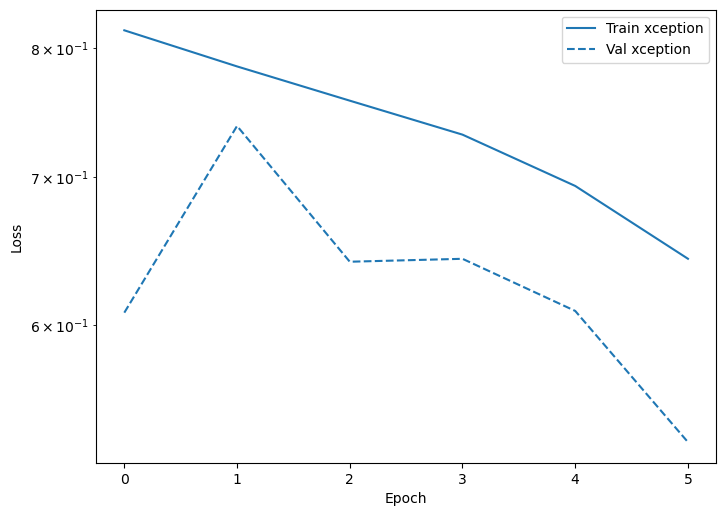

In [27]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# Plot loss

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history, 'xception', 0)

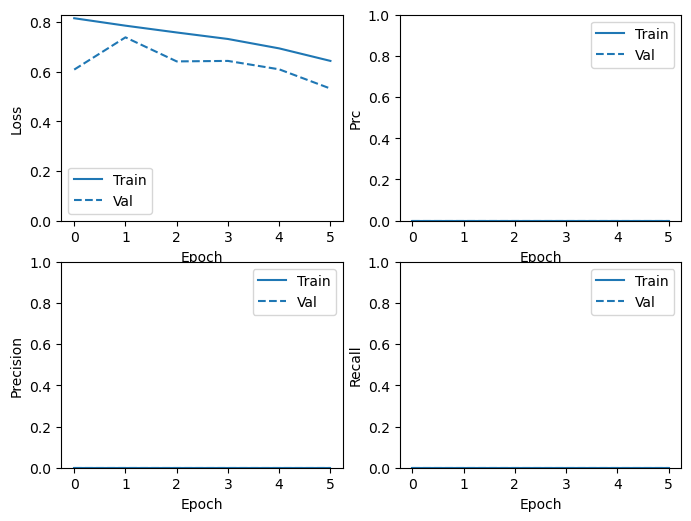

In [28]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [29]:
val_ds_x = []
val_ds_y = []

for _, (val_x_batch, val_y_batch) in enumerate(val_ds):
    for val_x, val_y in zip(val_x_batch, val_y_batch):
        val_ds_x.append(val_x)
        val_ds_y.append(val_y)

val_data = (tf.convert_to_tensor(val_ds_x, dtype=tf.float32), 
            tf.convert_to_tensor(val_ds_y, dtype=tf.float32))

val_data[0].numpy().shape

(1, 224, 224, 3)

In [31]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# sns.color_palette("mako", as_cmap=True)
class_names = ['fake', 'authentic'] # make sure its correct

test_predictions_baseline = model.predict(val_data[0].numpy(), batch_size=32)

## CHECK
def plot_cm(label_matrix, predictions):
    
    preds = np.around(np.squeeze(predictions))
    gt = np.around(np.squeeze(predictions))
    
    cm = confusion_matrix(gt, 
                          preds,
                          labels=np.array([0, 1]))
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

baseline_results = model.evaluate(val_data[0].numpy(), 
                                  val_data[1].numpy(),
                                  batch_size=32, 
                                  verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(val_data[1].numpy(), np.squeeze(test_predictions_baseline))

loss :  0.5315964221954346
accuracy :  1.0
precision :  0.0
recall :  0.0
auc :  0.0
prc :  0.0



TypeError: Singleton array 0.0 cannot be considered a valid collection.

In [ ]:
model.save_weights("detect_fake_img_model_weights.h5")